# Import Libraries

In [1]:
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Modèles Sklearn pour la comparaison
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score,precision_score,recall_score
from sklearn.preprocessing import StandardScaler




# Data Loading and Filtering

In [2]:
df = pd.read_csv("../fire_test/result_filtré.csv")
try:
    drop_cols = ['class']
    if 'Unnamed: 0' in df.columns:
        drop_cols.append('Unnamed: 0')

    y = df['class']
    X = df.drop(columns=drop_cols, errors='ignore')
except FileNotFoundError:
    print("Erreur: Le fichier ../fire_test/result.csv est introuvable.")



# Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Balancing Functions

In [4]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Après SMOTE: {Counter(y_train_smote)}")  

def random_undersampling(X, y):
    #Réduit la classe majoritaire pour égaler la classe minoritaire"""
    data = pd.concat([X, y], axis=1)
    count_class_0, count_class_1 = data['class'].value_counts()
    
    df_class_0 = data[data['class'] == 0]
    df_class_1 = data[data['class'] == 1]
    n_min = min(count_class_0, count_class_1)
    df_class_0_under = df_class_0.sample(n_min, random_state=42)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
    print(f"Après Undersampling: {Counter(df_test_under['class'])}")
    return df_test_under.drop('class', axis=1), df_test_under['class']

def random_oversampling(X, y):
    #Duplique la classe minoritaire pour égaler la classe majoritaire
    data = pd.concat([X, y], axis=1)
    count_class_0, count_class_1 = data['class'].value_counts()
    df_class_0 = data[data['class'] == 0]
    df_class_1 = data[data['class'] == 1]
    n_max = max(count_class_0, count_class_1)
    df_class_1_over = df_class_1.sample(n_max, replace=True, random_state=42)
    df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)
    
    print(f"Après Oversampling: {Counter(df_test_over['class'])}")
    return df_test_over.drop('class', axis=1), df_test_over['class']

print(f"Avant : {Counter(y_train)}")
X_train_over, y_train_over = random_oversampling(X_train, y_train)
X_train_under, y_train_under = random_undersampling(X_train, y_train)



c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Après SMOTE: Counter({0: 1445606, 1: 1445606})
Avant : Counter({0: 1445606, 1: 2127})
Après Oversampling: Counter({0: 1445606, 1: 1445606})
Après Undersampling: Counter({0: 2127, 1: 2127})


# SMOTE Oversampling

In [5]:
import numpy as np
import pandas as pd
import math

def discretize_auto(X, unit=1):  
    X_discrete = X.copy()
    N = len(X)  
    k = int(1 + (10/3) * math.log10(N))
    if k < 2:
        k = 2  

    for col in X_discrete.columns:
        if not np.issubdtype(X_discrete[col].dtype, np.number):
            continue
        col_min = X_discrete[col].min()
        col_max = X_discrete[col].max()
        w = (col_max - col_min + unit) / k
        bins = [col_min + i * w for i in range(k + 1)]

        X_discrete[col] = pd.cut(
            X_discrete[col],
            bins=bins,
            labels=[f"interval_{i}" for i in range(k)],
            include_lowest=True
        )
    return X_discrete


# Decision Tree Implementation

In [6]:
# import numpy as np
# import pandas as pd
# from collections import Counter
# import math


# def entropy(y):
#     counts = Counter(y)
#     total = len(y)
#     return -sum((c/total) * math.log2(c/total) for c in counts.values())

# def information_gain(y, x):
#     total_entropy = entropy(y)
#     values, counts = np.unique(x, return_counts=True)

#     weighted_entropy = 0
#     for v, c in zip(values, counts):
#         subset_y = y[x == v]
#         weighted_entropy += (c / len(x)) * entropy(subset_y)

#     return total_entropy - weighted_entropy


# class ID3:
#     def __init__(self):
#         self.tree = None
#     def fit(self, X, y):
#         data = X.copy()
#         data["class"] = y
#         self.tree = self._id3(data)
#         return self.tree

#     def _id3(self, data):
#         y = data["class"]
#         if len(set(y)) == 1:
#             return list(y)[0]
#         if len(data.columns) == 1:
#             return y.mode()[0]
#         gains = {col: information_gain(y, data[col]) for col in data.columns[:-1]}
#         best_attribute = max(gains, key=gains.get)

#         tree = {best_attribute: {}}

#         for v in data[best_attribute].unique():
#             subset = data[data[best_attribute] == v].drop(columns=[best_attribute])

#             if subset.empty:
#                 tree[best_attribute][v] = y.mode()[0]
#             else:
#                 tree[best_attribute][v] = self._id3(subset)

#         return tree

#     def predict_one(self, x, tree):
#         attribute = next(iter(tree))
#         value = x.get(attribute)

#         branch = tree[attribute].get(value, None)
#         if branch is None:
#             return None

#         if isinstance(branch, dict):
#             return self.predict_one(x, branch)
#         else:
#             return branch

#     def predict(self, X):
#         return [self.predict_one(row, self.tree) for _, row in X.iterrows()]





# Model Evaluation


OUVERSAMPLING
Accuracy : 0.9996656849038775
Precision: 0.889943074003795
Recall   : 0.881578947368421
F1 Score : 0.8857412653446648
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361402
           1       0.89      0.88      0.89       532

    accuracy                           1.00    361934
   macro avg       0.94      0.94      0.94    361934
weighted avg       1.00      1.00      1.00    361934



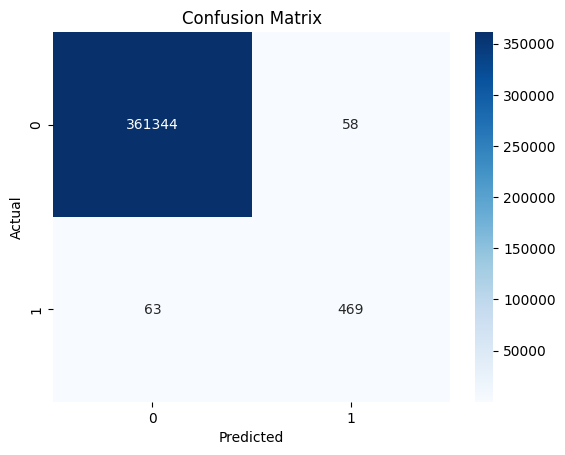


UNDERSAMPLING
Accuracy : 0.9522260964706273
Precision: 0.029373771412524573
Recall   : 0.9830827067669173
F1 Score : 0.05704313682718002
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    361402
           1       0.03      0.98      0.06       532

    accuracy                           0.95    361934
   macro avg       0.51      0.97      0.52    361934
weighted avg       1.00      0.95      0.97    361934



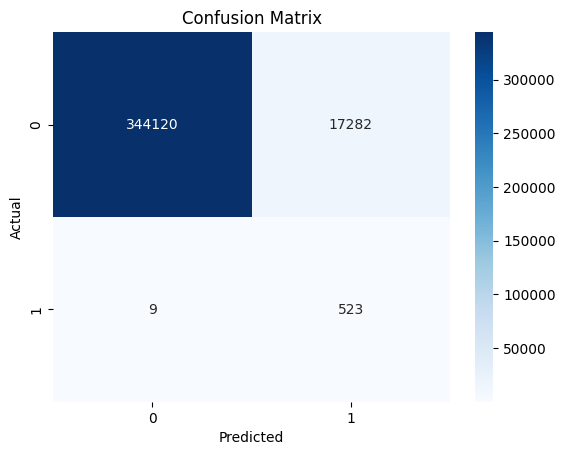


SMOTE
Accuracy : 0.9995551675167296
Precision: 0.8203799654576857
Recall   : 0.8928571428571429
F1 Score : 0.8550855085508551
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    361402
           1       0.82      0.89      0.86       532

    accuracy                           1.00    361934
   macro avg       0.91      0.95      0.93    361934
weighted avg       1.00      1.00      1.00    361934



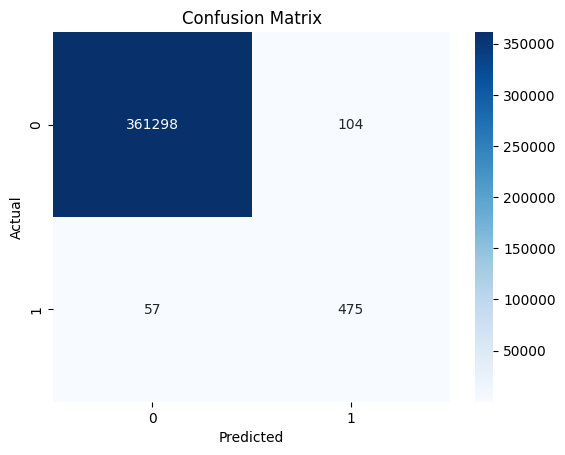

In [7]:

model = DecisionTreeClassifier(
    criterion="gini",      
    max_depth=None,        
    random_state=42
)

X_y = {
    "ouversampling": (X_train_over, y_train_over),
    "undersampling": (X_train_under, y_train_under),
    "SMOTE": (X_train_smote, y_train_smote)
}

for name, (X_train, y_train) in X_y.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name.upper()}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='binary'))
    print("Recall   :", recall_score(y_test, y_pred, average='binary'))
    print("F1 Score :", f1_score(y_test, y_pred, average='binary'))
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()